In [343]:
!pip install pyspark

In [344]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [345]:
df1 = spark.read.option("encoding", "UTF-8").csv("/content/Saude_covid.csv", sep = ";", inferSchema = True, header = True)
df1.show()


+--------------------+----------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+---------+--------------------------+--------+-----------------------------+--------+------------------------------+--------+------------------------------+
|           Indicador|Territorio|  Pais|Variavel de abertura|Categoria de abertura|Variavel de abertura2|Categoria de abertura2|     Maio|    Junho|Situacao Maio para Junho|    Julho|Situacao Junho para Julho|   Agosto|Situacao Julho para Agosto|Setembro|Situacao Agosto para Setembro| Outubro|Situacao Setembro para Outubro|Novembro|Situacao Outubro para Novembro|
+--------------------+----------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+---------+--------------------------+--------+-------------

In [346]:
df1.createOrReplaceTempView("Saude_covid")

In [347]:
SaudeCovid = spark.sql('''select * from Saude_covid''')
SaudeCovid.show()

+--------------------+----------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+---------+--------------------------+--------+-----------------------------+--------+------------------------------+--------+------------------------------+
|           Indicador|Territorio|  Pais|Variavel de abertura|Categoria de abertura|Variavel de abertura2|Categoria de abertura2|     Maio|    Junho|Situacao Maio para Junho|    Julho|Situacao Junho para Julho|   Agosto|Situacao Julho para Agosto|Setembro|Situacao Agosto para Setembro| Outubro|Situacao Setembro para Outubro|Novembro|Situacao Outubro para Novembro|
+--------------------+----------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+---------+--------------------------+--------+-------------

In [348]:
SaudeCovid.printSchema()

root
 |-- Indicador: string (nullable = true)
 |-- Territorio: string (nullable = true)
 |-- Pais: string (nullable = true)
 |-- Variavel de abertura: string (nullable = true)
 |-- Categoria de abertura: string (nullable = true)
 |-- Variavel de abertura2: string (nullable = true)
 |-- Categoria de abertura2: string (nullable = true)
 |-- Maio: string (nullable = true)
 |-- Junho: string (nullable = true)
 |-- Situacao Maio para Junho: string (nullable = true)
 |-- Julho: string (nullable = true)
 |-- Situacao Junho para Julho: string (nullable = true)
 |-- Agosto: string (nullable = true)
 |-- Situacao Julho para Agosto: string (nullable = true)
 |-- Setembro: string (nullable = true)
 |-- Situacao Agosto para Setembro: string (nullable = true)
 |-- Outubro: string (nullable = true)
 |-- Situacao Setembro para Outubro: string (nullable = true)
 |-- Novembro: string (nullable = true)
 |-- Situacao Outubro para Novembro: string (nullable = true)



## 1 - Apresentaram sintomas (sexo)

In [349]:
Pessoas_que_apresentaram_sintomas= spark.sql('''
    SELECT  `Categoria de abertura`,
    `Categoria de abertura2`, Maio, Junho, Julho, Agosto, Setembro, Outubro, Novembro
    FROM Saude_covid
    where Indicador = 'Pessoas que apresentaram algum dos sintoma(s) (mil pessoas)'
        AND Pais = 'Brasil'
        AND `Variavel de abertura` = 'Sexo'

        ''')
Pessoas_que_apresentaram_sintomas.show(100)


+---------------------+----------------------+---------+---------+---------+---------+--------+--------+--------+
|Categoria de abertura|Categoria de abertura2|     Maio|    Junho|    Julho|   Agosto|Setembro| Outubro|Novembro|
+---------------------+----------------------+---------+---------+---------+---------+--------+--------+--------+
|                Total|                     -|  24 012 |  15 506 |  13 793 |  12 136 |  9 237 |  7 811 |  7 956 |
|                Homem|                     -|  10 407 |   6 685 |   5 888 |   5 198 |  3 996 |  3 329 |  3 431 |
|               Mulher|                     -|  13 605 |   8 821 |   7 905 |   6 937 |  5 241 |  4 482 |  4 525 |
|                Total|                 Total|  24 012 |  15 506 |  13 793 |  12 136 |  9 237 |  7 811 |  7 956 |
|                Total|  Foi a estabelecim...|   3 768 |   2 979 |   3 141 |   2 833 |  2 227 |  2 084 |  2 293 |
|                Total|  Não foi a estabel...|  20 236 |  12 523 |  10 646 |   9 298 |  

## 1.1Primeiro entendimento

***Conseguimos definir que os meses mais importantes para análise serão os primeiros 3 (Maio, Junho e Julho) por terem o maior volume de procura por estabelecimentos de saúdo. Que é o objetivo da análise,
- quais são as principais ações que o Hospital deverá tomar caso haja um novo surto.

In [350]:
Pessoas_que_apresentaram_sintomas= spark.sql('''
    SELECT  `Categoria de abertura`,
    `Categoria de abertura2`, Maio, Junho, Julho
    FROM Saude_covid
    where Indicador = 'Pessoas que apresentaram algum dos sintoma(s) (mil pessoas)'
        AND Pais = 'Brasil'
        AND `Variavel de abertura` = 'Sexo'

        ''')
from pyspark.sql.functions import concat, lit
Pessoas_que_apresentaram_sintomas = Pessoas_que_apresentaram_sintomas \
    .withColumn("Nova_Coluna", concat(col("Categoria de abertura"), lit(" "), col("Categoria de abertura2"))) \
    .drop("Categoria de abertura", "Categoria de abertura2")

Pessoas_que_apresentaram_sintomas.show(100)


+---------+---------+---------+--------------------+
|     Maio|    Junho|    Julho|         Nova_Coluna|
+---------+---------+---------+--------------------+
|  24 012 |  15 506 |  13 793 |             Total -|
|  10 407 |   6 685 |   5 888 |             Homem -|
|  13 605 |   8 821 |   7 905 |            Mulher -|
|  24 012 |  15 506 |  13 793 |         Total Total|
|   3 768 |   2 979 |   3 141 |Total Foi a estab...|
|  20 236 |  12 523 |  10 646 |Total Não foi a e...|
|  10 407 |   6 685 |   5 888 |         Homem Total|
|   1 671 |   1 306 |   1 330 |Homem Foi a estab...|
|   8 734 |   5 379 |   4 554 |Homem Não foi a e...|
|  13 605 |   8 821 |   7 905 |        Mulher Total|
|   2 097 |   1 673 |   1 811 |Mulher Foi a esta...|
|  11 501 |   7 145 |   6 093 |Mulher Não foi a ...|
+---------+---------+---------+--------------------+



In [351]:
df_Pessoas_c_sintomas = Pessoas_que_apresentaram_sintomas.toPandas()
df_Pessoas_c_sintomas['Maio'] = df_Pessoas_c_sintomas['Maio'].str.replace(' ', '').astype('float64')
df_Pessoas_c_sintomas['Junho'] = df_Pessoas_c_sintomas['Junho'].str.replace(' ', '').astype('float64')
df_Pessoas_c_sintomas['Julho'] = df_Pessoas_c_sintomas['Julho'].str.replace(' ', '').astype('float64')

categorias = df_Pessoas_c_sintomas['Nova_Coluna'].tolist()
valores = df_Pessoas_c_sintomas[['Maio', 'Junho', 'Julho']].values.tolist()

In [352]:
df_Pessoas_c_sintomas

,Maio,Junho,Julho,Nova_Coluna
0,24012.0,15506.0,13793.0,Total -
1,10407.0,6685.0,5888.0,Homem -
2,13605.0,8821.0,7905.0,Mulher -
3,24012.0,15506.0,13793.0,Total Total
4,3768.0,2979.0,3141.0,Total Foi a estabelecimento de saúde
5,20236.0,12523.0,10646.0,Total Não foi a estabelecimento de saúde
6,10407.0,6685.0,5888.0,Homem Total
7,1671.0,1306.0,1330.0,Homem Foi a estabelecimento de saúde
8,8734.0,5379.0,4554.0,Homem Não foi a estabelecimento de saúde
9,13605.0,8821.0,7905.0,Mulher Total


In [353]:
df_Pessoas_c_sintomas = df_Pessoas_c_sintomas.drop([3, 6, 9])

df_Pessoas_c_sintomas['Nova_Coluna'] = df_Pessoas_c_sintomas['Nova_Coluna'].apply(lambda x: ' '.join(x.split()[:3]))

In [354]:
df_Pessoas_c_sintomas = df_Pessoas_c_sintomas.sort_values(by='Nova_Coluna')

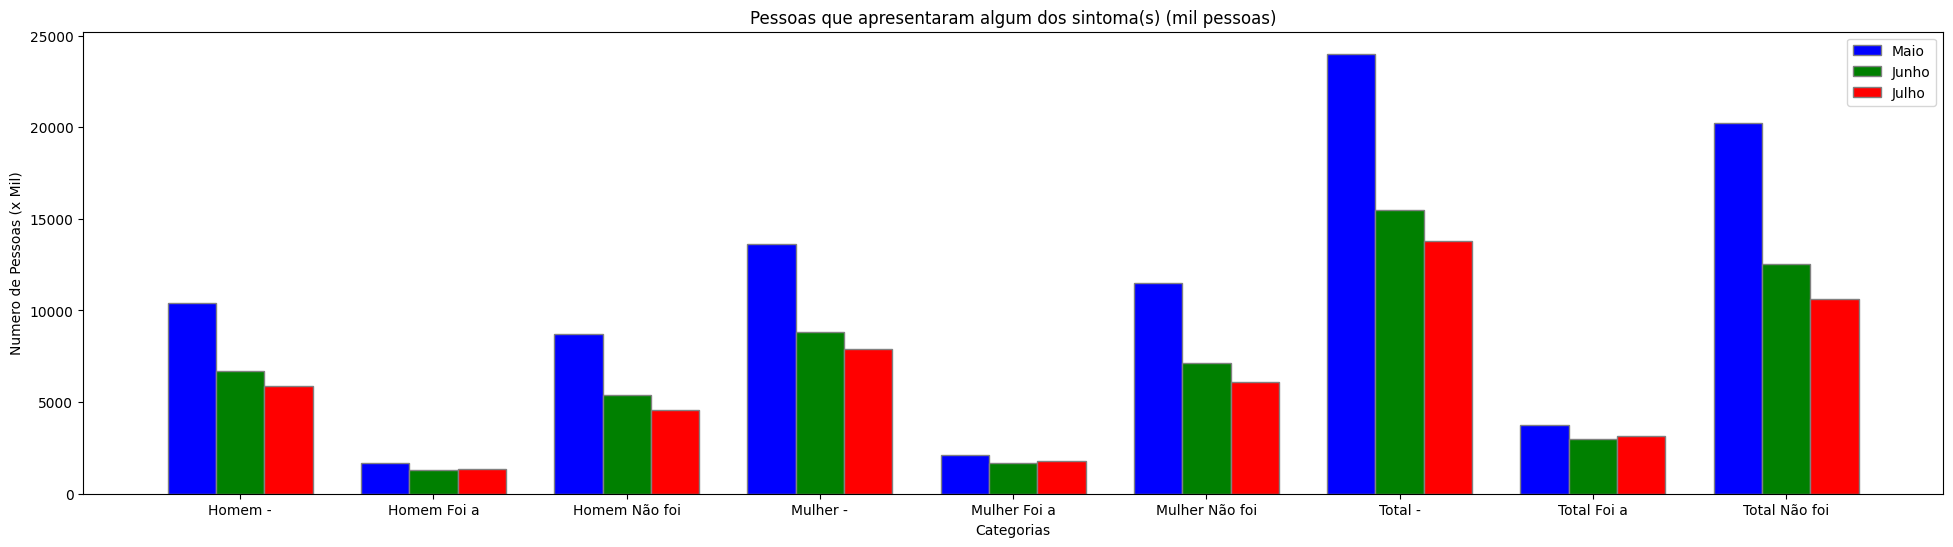

In [355]:
import numpy as np
import matplotlib.pyplot as plt

# Preparando os dados
categorias = df_Pessoas_c_sintomas['Nova_Coluna'].tolist()
valores = df_Pessoas_c_sintomas[['Maio', 'Junho', 'Julho']].values

# Definindo a largura das barras
bar_width = 0.25

# Definindo a posição das barras
r1 = np.arange(len(categorias))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Criando um gráfico de barras lado a lado
plt.figure(figsize=(24, 6))

plt.bar(r1, valores[:,0], color='b', width=bar_width, edgecolor='grey', label='Maio')
plt.bar(r2, valores[:,1], color='g', width=bar_width, edgecolor='grey', label='Junho')
plt.bar(r3, valores[:,2], color='r', width=bar_width, edgecolor='grey', label='Julho')

plt.xlabel('Categorias')
plt.ylabel('Numero de Pessoas (x Mil)')
plt.title('Pessoas que apresentaram algum dos sintoma(s) (mil pessoas)')
plt.xticks([r + bar_width for r in range(len(categorias))], categorias)
plt.legend()

# Exibe o gráfico
plt.show()

## Definições
 - A grande maioria não foi a nenhum estabelecimento de saúde. MAs os que foram foi um total de 5milhões e pessoas. Um número já considerado problerma se tratando as estrutura disponivel para atendimento.

 - Foram tanto homens quanto mulheres.

## 2 Apresentaram sintomas (Faixa Etária)

In [356]:
Apresentaram_sintomas_idade= spark.sql('''
    SELECT  `Categoria de abertura`,
    `Categoria de abertura2`, Maio, Junho, Julho
    FROM Saude_covid
    where Indicador = 'Pessoas que apresentaram algum dos sintoma(s) (mil pessoas)'
        AND Pais = 'Brasil'
        AND `Variavel de abertura` = 'Grupos de Idade 2'

        ''')
Apresentaram_sintomas_idade.show(100)

+---------------------+----------------------+---------+---------+---------+
|Categoria de abertura|Categoria de abertura2|     Maio|    Junho|    Julho|
+---------------------+----------------------+---------+---------+---------+
|               Total |                     -|  24 012 |  15 506 |  13 793 |
|         0 a 59 anos |                     -|  20 451 |  13 055 |  11 538 |
|     60 anos ou mais |                     -|   3 561 |   2 451 |   2 255 |
|               Total |                 Total|  24 012 |  15 506 |  13 793 |
|               Total |  Foi a estabelecim...|   3 768 |   2 979 |   3 141 |
|               Total |  Não foi a estabel...|  20 236 |  12 523 |  10 646 |
|         0 a 59 anos |                 Total|  20 451 |  13 055 |  11 538 |
|         0 a 59 anos |  Foi a estabelecim...|   3 224 |   2 514 |   2 674 |
|         0 a 59 anos |  Não foi a estabel...|  17 221 |  10 538 |   8 860 |
|     60 anos ou mais |                 Total|   3 561 |   2 451 |   2 255 |

In [357]:
Apresentaram_sintomas_idade = Apresentaram_sintomas_idade.toPandas()
Apresentaram_sintomas_idade['Maio'] = Apresentaram_sintomas_idade['Maio'].str.replace(' ', '').astype('float64')
Apresentaram_sintomas_idade['Junho'] = Apresentaram_sintomas_idade['Junho'].str.replace(' ', '').astype('float64')
Apresentaram_sintomas_idade['Julho'] = Apresentaram_sintomas_idade['Julho'].str.replace(' ', '').astype('float64')
Apresentaram_sintomas_idade

,Categoria de abertura,Categoria de abertura2,Maio,Junho,Julho
0,Total,-,24012.0,15506.0,13793.0
1,0 a 59 anos,-,20451.0,13055.0,11538.0
2,60 anos ou mais,-,3561.0,2451.0,2255.0
3,Total,Total,24012.0,15506.0,13793.0
4,Total,Foi a estabelecimento de saúde,3768.0,2979.0,3141.0
5,Total,Não foi a estabelecimento de saúde,20236.0,12523.0,10646.0
6,0 a 59 anos,Total,20451.0,13055.0,11538.0
7,0 a 59 anos,Foi a estabelecimento de saúde,3224.0,2514.0,2674.0
8,0 a 59 anos,Não foi a estabelecimento de saúde,17221.0,10538.0,8860.0
9,60 anos ou mais,Total,3561.0,2451.0,2255.0


In [358]:
Apresentaram_sintomas_idade = Apresentaram_sintomas_idade.drop([3,4,5, 6, 9])

Apresentaram_sintomas_idade['Nova_Coluna'] = Apresentaram_sintomas_idade['Categoria de abertura'] + ' ' + Apresentaram_sintomas_idade['Categoria de abertura2']

Apresentaram_sintomas_idade['Nova_Coluna'] = Apresentaram_sintomas_idade['Nova_Coluna'].apply(lambda x: ' '.join(x.split()[:6]))

In [359]:
Apresentaram_sintomas_idade

,Categoria de abertura,Categoria de abertura2,Maio,Junho,Julho,Nova_Coluna
0,Total,-,24012.0,15506.0,13793.0,Total -
1,0 a 59 anos,-,20451.0,13055.0,11538.0,0 a 59 anos -
2,60 anos ou mais,-,3561.0,2451.0,2255.0,60 anos ou mais -
7,0 a 59 anos,Foi a estabelecimento de saúde,3224.0,2514.0,2674.0,0 a 59 anos Foi a
8,0 a 59 anos,Não foi a estabelecimento de saúde,17221.0,10538.0,8860.0,0 a 59 anos Não foi
10,60 anos ou mais,Foi a estabelecimento de saúde,545.0,465.0,467.0,60 anos ou mais Foi a
11,60 anos ou mais,Não foi a estabelecimento de saúde,3015.0,1986.0,1787.0,60 anos ou mais Não foi


In [360]:
Apresentaram_sintomas_idade = Apresentaram_sintomas_idade.sort_values(by='Categoria de abertura')

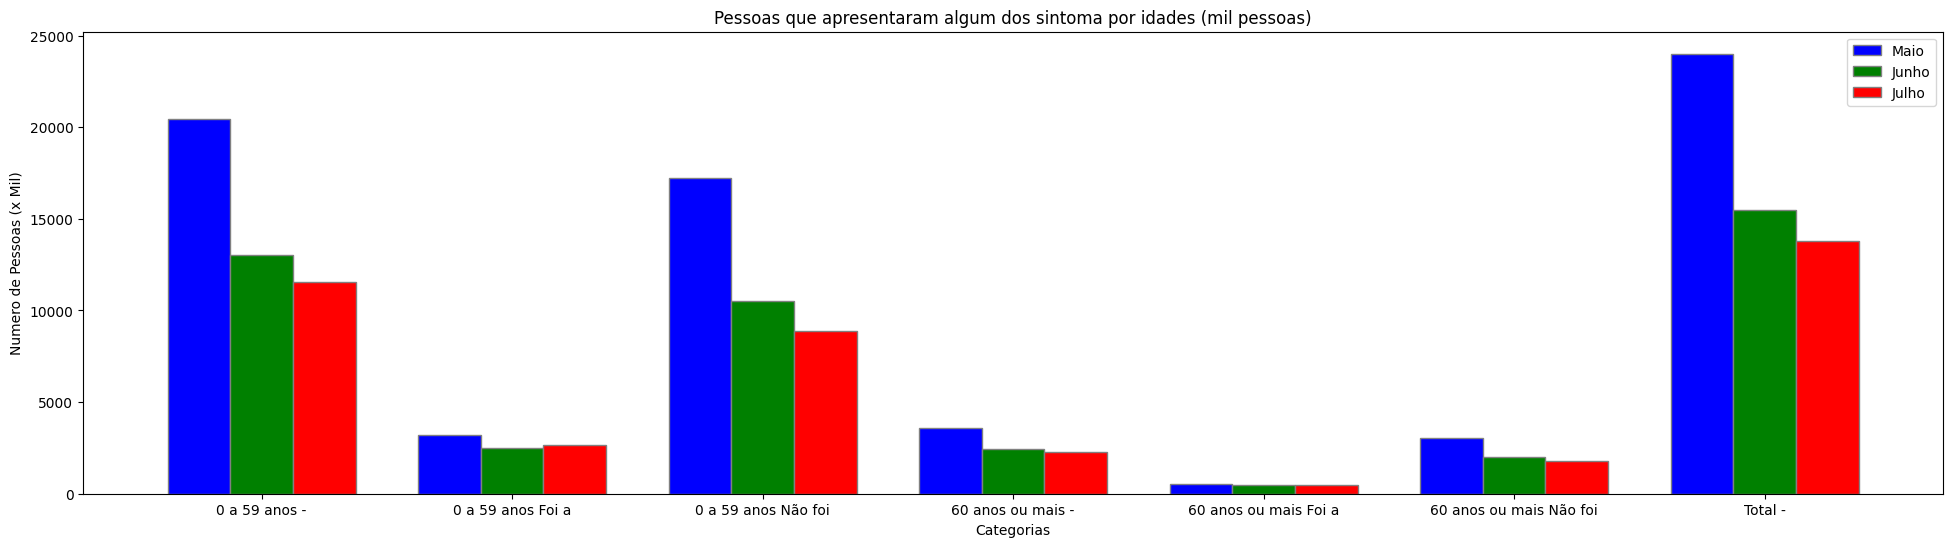

In [361]:
import numpy as np
import matplotlib.pyplot as plt

categorias = Apresentaram_sintomas_idade['Nova_Coluna'].tolist()
valores = Apresentaram_sintomas_idade[['Maio', 'Junho', 'Julho']].values.tolist()

bar_width = 0.25

r1 = np.arange(len(categorias))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(24, 6))
valores = np.array(valores)

plt.bar(r1, valores[:,0], color='b', width=bar_width, edgecolor='grey', label='Maio')
plt.bar(r2, valores[:,1], color='g', width=bar_width, edgecolor='grey', label='Junho')
plt.bar(r3, valores[:,2], color='r', width=bar_width, edgecolor='grey', label='Julho')

plt.xlabel('Categorias')
plt.ylabel('Numero de Pessoas (x Mil)')
plt.title('Pessoas que apresentaram algum dos sintoma por idades (mil pessoas)')
plt.xticks([r + bar_width for r in range(len(categorias))], categorias)
plt.legend()

plt.show()

## - A grande maioria das pessoas que tiveram sintomas foram as pessoas entre  0 e 59  anos. E também representaram a maioria do que procuraram um sistema de saúde.

## 3. Procuraram Atendimento em Hospitais (Faixa Etária)

In [363]:
Foram_a_hospitais_idade= spark.sql('''
    SELECT  *
    FROM Saude_covid
    where Indicador
     = 'Pessoas que não procuraram atendimento em estabelecimento de saúde (mil pessoas)'
    ''')
Foram_a_hospitais_idade.show(100)

+--------------------+-------------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+--------+--------------------------+--------+-----------------------------+--------+------------------------------+--------+------------------------------+
|           Indicador|   Territorio|  Pais|Variavel de abertura|Categoria de abertura|Variavel de abertura2|Categoria de abertura2|     Maio|    Junho|Situacao Maio para Junho|    Julho|Situacao Junho para Julho|  Agosto|Situacao Julho para Agosto|Setembro|Situacao Agosto para Setembro| Outubro|Situacao Setembro para Outubro|Novembro|Situacao Outubro para Novembro|
+--------------------+-------------+------+--------------------+---------------------+---------------------+----------------------+---------+---------+------------------------+---------+-------------------------+--------+--------------------------+--------+-------